<center><h1>Projet Robotique</h1></center>
<center><h2>Classification via LSTM</h2></center>

# Importation des librairies

In [ ]:
!pip install bayesian-optimization

In [ ]:
import os
from google.colab import drive

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_curve, auc, roc_auc_score, precision_recall_curve

from bayes_opt import BayesianOptimization

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.optimizers import Adam
from keras.api._v2.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')
# disable tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Configaration GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at:{}".format(device_name))
else:
    device_name="/device:CPU:0"
    print("No GPU")

Found GPU at:/device:GPU:0


# Importation du dataset

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Robotique/preprocessed_data.csv")

df

,MILLISEC,Accelerometer RKN^ accX,Accelerometer RKN^ accY,Accelerometer RKN^ accZ,Accelerometer HIP accX,Accelerometer HIP accY,Accelerometer HIP accZ,Accelerometer LUA^ accX,Accelerometer LUA^ accY,Accelerometer LUA^ accZ,...,LOCATION TAG4 X,LOCATION TAG4 Y,LOCATION TAG4 Z,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,-1.585284,0.146747,0.337532,-1.410530,0.693260,0.434434,0.074936,-0.199117,0.621667,-0.455638,...,0.147947,0.811792,0.186199,0,0,0,0,0,0,0
1,-1.585185,0.263802,0.342378,-1.626921,0.626338,0.487110,0.200034,-0.108635,0.598101,-0.542260,...,0.147947,0.812691,0.178270,0,0,0,0,0,0,0
2,-1.585083,0.194202,0.371457,-1.735116,0.470187,0.527630,0.179184,-0.099275,0.709202,-0.572130,...,0.147947,0.814490,0.172322,0,0,0,0,0,0,0
3,-1.584985,0.058164,0.153369,-1.616313,0.618902,0.523578,0.210459,-0.152316,0.729402,-0.593039,...,0.147947,0.816289,0.172322,0,0,0,0,0,0,0
4,-1.584886,0.247984,0.290684,-1.705415,0.570570,0.535734,0.161809,-0.189757,0.709202,-0.634857,...,0.149055,0.818988,0.176287,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606043,1.407215,0.640278,0.298761,-0.141884,0.358651,0.102168,0.787298,0.418657,0.540867,-0.067329,...,0.129671,0.139901,0.208006,0,0,0,0,0,0,0
606044,1.407317,0.437804,0.297145,-0.020960,0.291729,0.102168,0.776873,0.452977,0.483633,-0.195770,...,0.129117,0.138102,0.206023,0,0,0,0,0,0,0
606045,1.407416,0.678242,0.240604,-0.001866,0.143014,0.110272,0.915871,0.393696,0.503833,-0.195770,...,0.129117,0.136303,0.202059,0,0,0,0,0,0,0
606046,1.407514,1.155955,0.159831,-0.046417,0.098399,0.256145,0.780348,0.362495,0.577900,-0.276418,...,0.129671,0.134504,0.200076,0,0,0,0,0,0,0


# Fonctions diverses

# Fonctions de feature selection

In [ ]:
def dim_reduction(df, n):
    """
    Perform dimensionality reduction using PCA.

    Args:
    df (pandas.DataFrame): Input DataFrame.
    n (int): Number of components for dimensionality reduction.

    Returns:
    pandas.DataFrame: DataFrame with reduced dimensions.
    """
    pca = PCA(n_components=n)
    pca.fit(df)
    reducted_df = pca.fit_transform(df)

    # Create column names for the reduced dimensions
    columns_name = [f'column{i}' for i in range(1, pca.n_components_ + 1)]

    return pd.DataFrame(reducted_df, columns=columns_name)

In [ ]:
def correlation(dataset, threshold):
    """
    Remove columns with high correlation from the input DataFrame.

    Args:
    dataset (pandas.DataFrame): Input DataFrame.
    threshold (float): Correlation threshold for column removal.

    Returns:
    pandas.DataFrame: DataFrame with correlated columns removed.
    """
    df = dataset.copy()
    col_corr = set()  # For storing unique columns with high correlation
    corr_matrix = dataset.corr()

    # Iterate through the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # Check if the absolute correlation value is greater than the threshold
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)

    # Drop columns with high correlation
    df.drop(col_corr, axis=1, inplace=True)

    return df

## Fonction de segmentation du dataset  

In [ ]:
def data_segmentation(data_collection, window_size, label):
    """
    Segment the data and create a dataset with a choosen labels.

    Args:
    data_collection (pandas.DataFrame): Input DataFrame.
    window_size (int): Size of the segmentation window.
    label (str): Name of the column to be used as the target label.

    Returns:
    numpy.ndarray: Segmented input features (X).
    numpy.ndarray: Corresponding labels (y).
    """
    loco_i = data_collection.columns.get_loc(label)

    # Convert the DataFrame to a numpy array
    data = data_collection.to_numpy()

    # Segment the data
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0

    while start + window_size - 1 < n:
        end = start + window_size - 1

        # Check if the frame contains the same activity and is from the same file
        if data[start][loco_i] == data[end][loco_i] and data[start][-1] == data[end][-1]:
            X.append(data[start:(end+1), :])
            y.append(data[start][loco_i])
            start += window_size // 2  # 50% overlap
        else:
            # If the frame contains different activities or is from different objects, find the next start point
            while start + window_size - 1 < n:
                if data[start][loco_i] != data[start+1][loco_i]:
                    break
                start += 1
            start += 1

    return np.asarray(X), np.asarray(y)

## Fonction d'entrainement du modèle

In [ ]:
def lstm_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp, v):
    nbn_l = int(nbn_l)
    nbn_d = int(nbn_d)
    bs = int(bs)
    with tf.device(device_name):

      model = Sequential()

      model.add(LSTM(units=nbn_l, activation='tanh', return_sequences=True, input_shape=X_train[0].shape))

      model.add(LSTM(units=nbn_l//2, activation='tanh', return_sequences=True, input_shape=X_train[0].shape))

      model.add(LSTM(units=nbn_l//4, activation='tanh', return_sequences=True, input_shape=X_train[0].shape))

      model.add(LSTM(units=nbn_l//8, activation='tanh'))

      model.add(Flatten())
      model.add(Dense(nbn_d, activation='elu'))
      model.add(Dropout(dp))
      model.add(Dense(nbn_l//2, activation='elu'))
      model.add(Dropout(dp))
      model.add(Dense(5, activation='softmax'))


      model.compile(optimizer = Adam(learning_rate=lr),
                    loss = 'categorical_crossentropy',
                    metrics =[tf.keras.metrics.TruePositives(name='tp'),
                          tf.keras.metrics.FalsePositives(name='fp'),
                          tf.keras.metrics.TrueNegatives(name='tn'),
                          tf.keras.metrics.FalseNegatives(name='fn'),
                          'accuracy',
                          tf.keras.metrics.Precision(name='precision'),
                          tf.keras.metrics.Recall(name='recall'),
                          tf.keras.metrics.AUC(name='auc')])

      checkpointer = ModelCheckpoint(filepath='test.keras', monitor='accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq=1)
      early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')

      history = model.fit(X_train, y_train,
                              batch_size=bs, epochs=100,
                              verbose=v,
                              callbacks = [checkpointer, early],
                              validation_data=(X_val, y_val))

      return history, model

## Fonction de la pipeline à utiliser

In [ ]:
def pipeline(method,threshold,nbn_l, nbn_d, lr, bs, dp):
    """
    Perform a LSTM model pipeline with dimensionality reduction or correlation removal.

    Args:
    method (int): Method for data preprocessing. 1: Dimensionality reduction, 2: Correlation removal.
    threshold (float): Threshold for dimensionality reduction or correlation removal.
    nbn_l (int): Number of LSTM units.
    nbn_d (int): Number of dense units.
    lr (float): Learning rate.
    bs (int): Batch size.
    dp (float): Dropout rate.

    Returns:
    float: Accuracy score of the LSTM model.
    """

    if method <= 1:
      dataset = dim_reduction(df[df.columns[:-7]], threshold)
    elif method <= 2:
      dataset = correlation(df[df.columns[:-7]], threshold)

    labels = df[df.columns[-7:]]
    dataset = pd.concat([dataset, labels], axis=1)

    X, y = data_segmentation(dataCollection=df, window_size=25, label='HL_Activity')

    y = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

    history, model = lstm_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp, 0)
    acc = history.history['val_accuracy'][-1]

    return acc

# Affinage de la pipeline via l'optimisation Bayesienne

In [ ]:
# Define parameter bounds for optimization
pbounds = {
    'method': (0, 2),
    'tresh': (0.1, 0.99),
    'nbn_l': (256, 1024),
    'nbn_d': (256, 1024),
    'lr': (1e-6, 1e-2),
    'bs': (32, 512),
    'dp': (0.1, 0.5)
    }

# Create BayesianOptimization instance
optimizer = BayesianOptimization(
    f=pipeline,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

# Perform Bayesian optimization
optimizer.maximize(init_points=10, n_iter=10)

# Print the best set of parameters and the corresponding maximum accuracy score
print(optimizer.max)

|   iter    |  target   |    bs     |    dp     |    lr     |  method   |   nbn_d   |   nbn_l   |   tresh   |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9838    | 232.2     | 0.3881    | 1.011e-06 | 0.6047    | 368.7     | 326.9     | 0.2658    |
| 2         | 0.9868    | 197.9     | 0.2587    | 5.434e-06 | 0.8384    | 782.2     | 413.0     | 0.8815    |
| 3         | 0.9868    | 45.15     | 0.3682    | 4.231e-05 | 1.117     | 363.8     | 408.1     | 0.8127    |
| 4         | 0.978     | 496.8     | 0.2254    | 6.954e-03 | 1.753     | 943.1     | 321.3     | 0.1348    |
| 5         | 0.9824    | 113.5     | 0.4513    | 1.074e-05 | 0.8422    | 991.7     | 665.5     | 0.7158    |
| 6         | 0.9648    | 183.4     | 0.3746    | 8.363e-05 | 0.03658   | 832.1     | 1.015e+03 | 0.7659    |
| 7         | 0.9883    | 166.6     | 0.4157    | 1.122e-04 | 0.8958    | 953.8     | 481.5     | 0.3561    |
| 8       

# Préparation du dataset pour l'entrainement avec les hyperparamètres optimaux

## Feature selection

In [ ]:
# Get the best set of parameters
method = optimizer['params']['method']
tresh = optimizer['params']['tresh']

# Apply the best feature selection method for this scenario
if method <= 1:
    dataset = dim_reduction(df[df.columns[:-7]], tresh)
elif method <= 2:
    dataset = correlation(df[df.columns[:-7]], tresh)

# Concatenate the selected features with the labels
labels = df[df.columns[-7:]]
dataset = pd.concat([dataset, labels], axis=1)

dataset

,MILLISEC,Accelerometer RKN^ accX,Accelerometer RKN^ accY,Accelerometer RKN^ accZ,Accelerometer HIP accX,Accelerometer HIP accY,Accelerometer HIP accZ,Accelerometer LUA^ accX,Accelerometer LH accX,Accelerometer LH accZ,...,Accelerometer FRIDGE accX,Accelerometer FRIDGE accY,LOCATION TAG1 X,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,-1.585284,0.146747,0.337532,-1.410530,0.693260,0.434434,0.074936,-0.199117,-0.287427,0.335051,...,-0.424433,0.568190,0.197956,0,0,0,0,0,0,0
1,-1.585185,0.263802,0.342378,-1.626921,0.626338,0.487110,0.200034,-0.108635,-0.223851,0.329940,...,-0.479332,0.206989,0.194403,0,0,0,0,0,0,0
2,-1.585083,0.194202,0.371457,-1.735116,0.470187,0.527630,0.179184,-0.099275,-0.386938,0.378494,...,-0.351234,0.413389,0.194995,0,0,0,0,0,0,0
3,-1.584985,0.058164,0.153369,-1.616313,0.618902,0.523578,0.210459,-0.152316,-0.328890,0.388716,...,-0.204835,1.084190,0.200324,0,0,0,0,0,0,0
4,-1.584886,0.247984,0.290684,-1.705415,0.570570,0.535734,0.161809,-0.189757,-0.447750,0.565044,...,-0.396983,0.258589,0.210983,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606043,1.407215,0.640278,0.298761,-0.141884,0.358651,0.102168,0.787298,0.418657,-0.292956,0.253276,...,0.179460,0.206989,0.432449,0,0,0,0,0,0,0
606044,1.407317,0.437804,0.297145,-0.020960,0.291729,0.102168,0.776873,0.452977,-0.229379,0.243054,...,0.106261,0.310189,0.431857,0,0,0,0,0,0,0
606045,1.407416,0.678242,0.240604,-0.001866,0.143014,0.110272,0.915871,0.393696,-0.223851,0.161278,...,0.280108,-0.051012,0.432449,0,0,0,0,0,0,0
606046,1.407514,1.155955,0.159831,-0.046417,0.098399,0.256145,0.780348,0.362495,-0.135397,0.191944,...,0.097111,-0.309012,0.433633,0,0,0,0,0,0,0


## Segmentation du dataset

In [ ]:
X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

X.shape, y.shape

((4122, 25, 91), (4122,))

## Division des données en train, val et test sets

In [ ]:
# categorize the data
y = to_categorical(y)

# split the data into train, validation and test sets using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", X_train.shape)
print("Shape of the validation set: ", X_val.shape)
print("Shape of the test set: ", X_test.shape)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", y_train.shape)
print("Shape of the validation set: ", y_val.shape)
print("Shape of the test set: ", y_test.shape)

Shape of the train set:  (2761, 25, 91)
Shape of the validation set:  (681, 25, 91)
Shape of the test set:  (680, 25, 91)
Shape of the train set:  (2761, 5)
Shape of the validation set:  (681, 5)
Shape of the test set:  (680, 5)


# Entrainement du dataset avec les hyperparamètres optimaux

In [ ]:
# Get the best set of parameters
nbn_l = optimizer['params']['nbn_l']
nbn_d = optimizer['params']['nbn_d']
lr = optimizer['params']['lr']
dp = optimizer['params']['dp']
bs = optimizer['params']['bs']

history, model = lstm_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp, 2)

Epoch 1/100
87/87 - 13s - loss: 0.3851 - tp: 2270.0000 - fp: 201.0000 - tn: 10843.0000 - fn: 491.0000 - accuracy: 0.8776 - precision: 0.9187 - recall: 0.8222 - auc: 0.9809 - val_loss: 0.1347 - val_tp: 652.0000 - val_fp: 28.0000 - val_tn: 2696.0000 - val_fn: 29.0000 - val_accuracy: 0.9589 - val_precision: 0.9588 - val_recall: 0.9574 - val_auc: 0.9966 - 13s/epoch - 147ms/step
Epoch 2/100
87/87 - 1s - loss: 0.1654 - tp: 2610.0000 - fp: 127.0000 - tn: 10917.0000 - fn: 151.0000 - accuracy: 0.9489 - precision: 0.9536 - recall: 0.9453 - auc: 0.9948 - val_loss: 0.2058 - val_tp: 640.0000 - val_fp: 37.0000 - val_tn: 2687.0000 - val_fn: 41.0000 - val_accuracy: 0.9413 - val_precision: 0.9453 - val_recall: 0.9398 - val_auc: 0.9923 - 1s/epoch - 13ms/step
Epoch 3/100
87/87 - 1s - loss: 0.0568 - tp: 2714.0000 - fp: 45.0000 - tn: 10999.0000 - fn: 47.0000 - accuracy: 0.9830 - precision: 0.9837 - recall: 0.9830 - auc: 0.9985 - val_loss: 0.1463 - val_tp: 646.0000 - val_fp: 33.0000 - val_tn: 2691.0000 - va

# Evaluation du modèle

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.019262118265032768
Test accuracy: 678.0


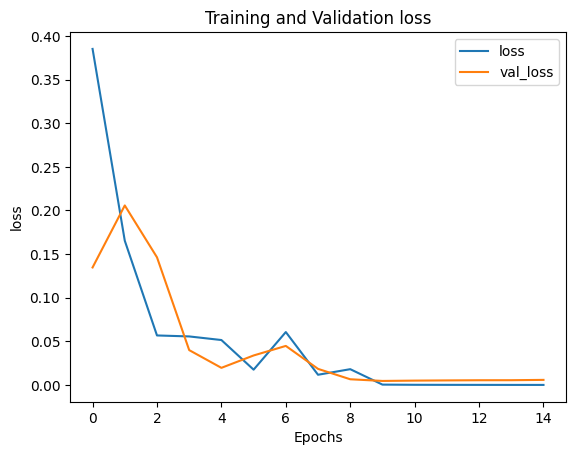

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.title('Training and Validation loss')
plt.show()

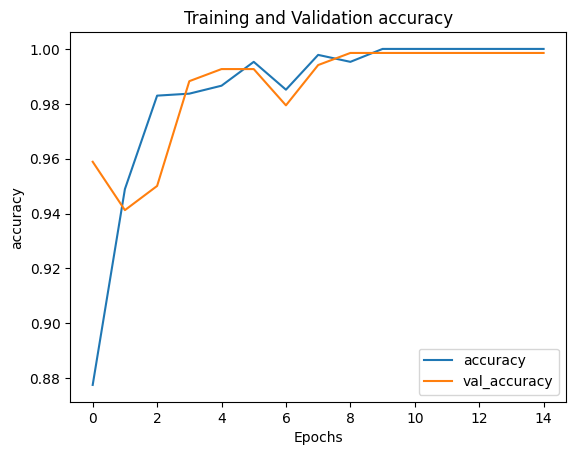

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Training and Validation accuracy')
plt.show()

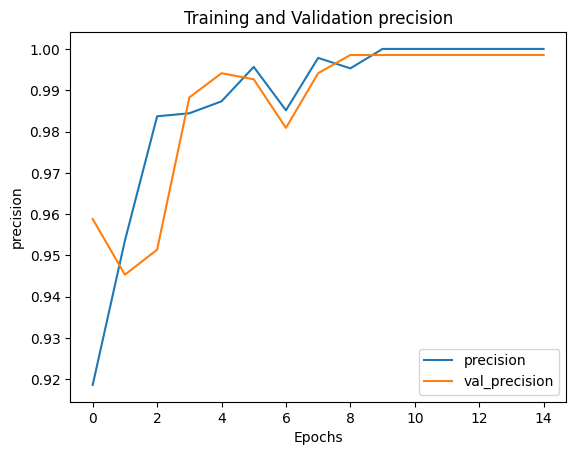

In [ ]:
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='Validation precision')
plt.xlabel("Epochs")
plt.ylabel('precision')
plt.legend(['precision', 'val_precision'])
plt.title('Training and Validation precision')
plt.show()

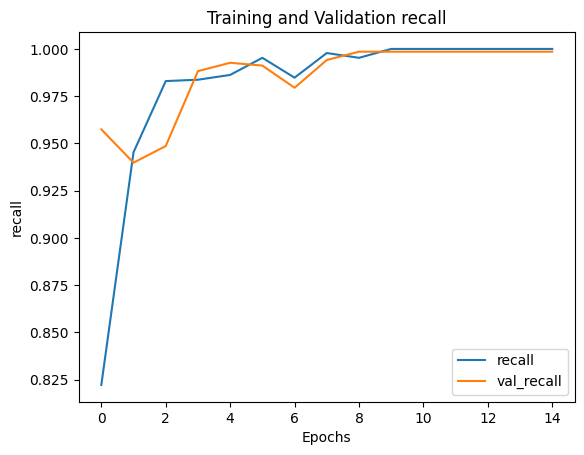

In [ ]:
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='Validation recall')
plt.xlabel("Epochs")
plt.ylabel('recall')
plt.legend(['recall', 'val_recall'])
plt.title('Training and Validation recall')
plt.show()

In [ ]:
def model_evaluate(model, target, testX, testy):
  y_pred = model.predict(testX)
  y_pred = np.argmax(y_pred, axis=1)
  y_test = np.argmax(testy, axis=1)

  # Confusion matrix
  print('Confusion Matrix')

  cm = confusion_matrix(y_test, y_pred)

  # Calculate accuracy
  conf_acc = accuracy_score(y_test, y_pred) * 100
  print("Accuracy for Test Data = ", conf_acc)

  plt.figure(figsize = (12,8))
  sns.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

  # Classification Report
  print('\nClassification Report')
  print(classification_report(y_test, y_pred))

  # Cohen Kappa Score
  print('\nCohen Kappa Score')
  print(cohen_kappa_score(y_test, y_pred))

  # Precision vs Recall Curve
  print('\nPrecision vs Recall Curve')
  _, c_ax = plt.subplots(1,1, figsize = (12, 8))

  y_test = tf.keras.utils.to_categorical(y_test)
  y_pred = tf.keras.utils.to_categorical(y_pred)
  n_classes = 2

  precision = dict()
  recall = dict()

  for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                          y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

  plt.xlabel("recall")
  plt.ylabel("precision")
  plt.legend(loc="best")
  plt.title("Precision vs. Recall curve")
  plt.show()

  # ROC Curve
  print('\nROC Curve')
  average = 'macro'
  fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
  for (idx, c_label) in enumerate(target):
      fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
      c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
  c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  print('ROC AUC score:', roc_auc_score(y_test, y_pred, average=average))

  c_ax.legend()
  c_ax.set_xlabel('False Positive Rate')
  c_ax.set_ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()

22/22 [==============================] - 0s 5ms/step
Confusion Matrix
Accuracy for Test Data =  100.0


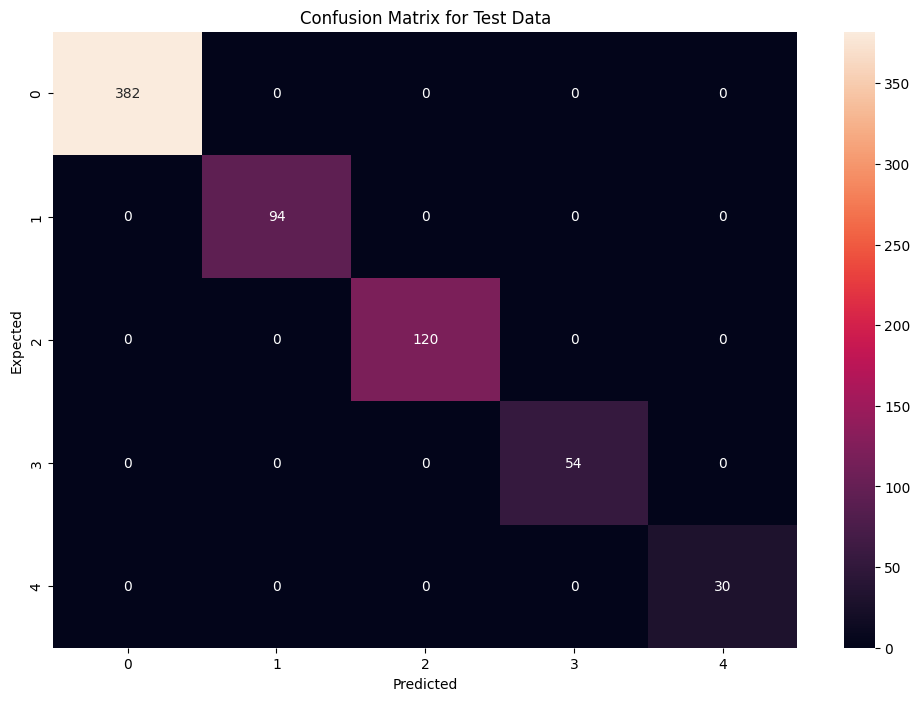


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       382
           1       1.00      1.00      1.00        94
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00        54
           4       1.00      1.00      1.00        30

    accuracy                           1.00       680
   macro avg       1.00      1.00      1.00       680
weighted avg       1.00      1.00      1.00       680


Cohen Kappa Score
1.0

Precision vs Recall Curve


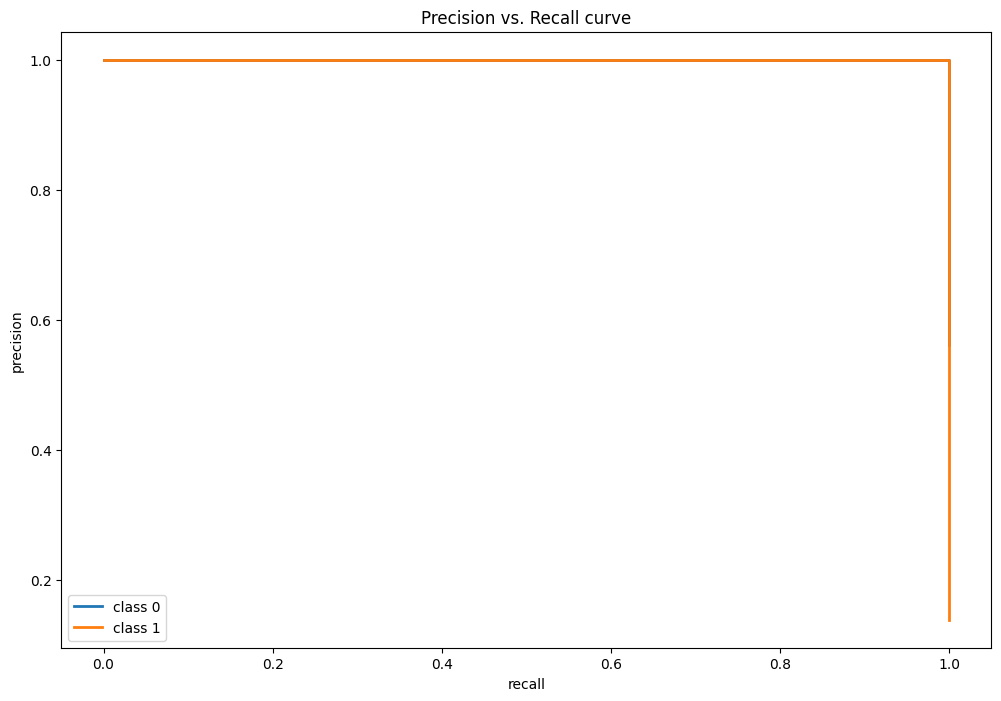


ROC Curve
ROC AUC score: 1.0


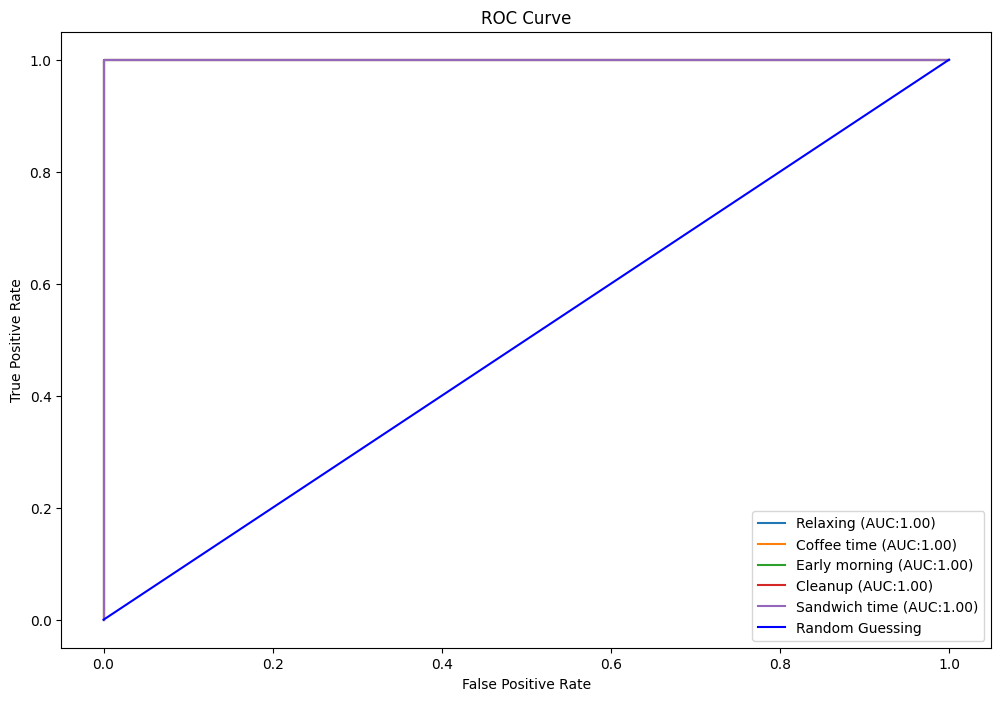

In [ ]:
model_evaluate(model, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], X_test, y_test)

In [ ]:
pd.DataFrame([[history.history['loss'][-1], history.history['accuracy'][-1], history.history['precision'][-1], history.history['recall'][-1], history.history['tp'][-1], history.history['tn'][-1], history.history['fn'][-1], history.history['fp'][-1], history.history['auc'][-1]]],  columns=["loss", "accuracy", "precision", "recall", "true positive", "true negative", "false positive", "false negative", "area under the curve"])

,loss,accuracy,precision,recall,true positive,true negative,false positive,false negative,area under the curve
0,0.000082,1.0,1.0,1.0,2761.0,11044.0,0.0,0.0,1.0
